In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework 1

#libraries and warnings

In [ ]:
seed = 420

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

#Load and dataset preprocess

In [ ]:
unzip = True

if unzip:
    !unzip dataset.zip

dataset = np.load('dataset_wo_duplicates.npz', allow_pickle=True)

In [ ]:
#load and process images from a dataset

def load_images():
    images = []
    for item in dataset['data']:
        img = item
        #normalization to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        #resizing images dimension in 96x96 pixels
        img = tfkl.Resizing(96,96)(img)
        if img is not None:
            images.append(img)
    return np.array(images)

In [ ]:
X = load_images()
y = dataset['labels']
_ , y = np.unique(y, return_inverse=True)
y = tfk.utils.to_categorical(y, 2)



In [ ]:
num_h,num_u = 0,0
dim_data = len(dataset["data"])
print(dim_data)

for i in range(dim_data):
  if dataset['labels'][i] == "healthy":
    num_h+=1
  else:
    num_u+=1
print(num_h)
print(num_u)

4739
3028
1711


In [ ]:
#creating weights for the classes based on the number of elements for each class
weight_h = (1/num_h)*(dim_data/2)
weight_u = (1/num_u)*(dim_data/2)
class_weight = {0: weight_u,1:weight_h}
print('Weight for class 0: {:.2f}'.format(weight_h))
print('Weight for class 1: {:.2f}'.format(weight_u))

In [ ]:
#visualization utility for plotting training histories in particular accuracy and loss
def print_histories(metadata):
  plt.figure(figsize=(15,5))
  for k in list(metadata.keys()):
    plt.plot(metadata[k]['history']['loss'], alpha=.25, color=metadata[k]['color'][0], linestyle='--')
    plt.plot(metadata[k]['history']['val_loss'], label=k, alpha=.9, color=metadata[k]['color'][0])
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.15)
  plt.figure(figsize=(15,5))
  for k in list(metadata.keys()):
    be = metadata[k]['best_epoch']
    bescore = metadata[k]['history']['val_accuracy'][be]
    plt.plot(metadata[k]['history']['accuracy'], alpha=.25, color=metadata[k]['color'][1], linestyle='--')
    plt.plot(metadata[k]['history']['val_accuracy'], label=k, alpha=.9, color=metadata[k]['color'][1])
    plt.plot(be, bescore, marker='*', color=metadata[k]['color'][1], markersize=15)
    plt.text(0.95*be, 1.02*bescore,
             f'best_epoch={bescore}', fontsize=12, color=metadata[k]['color'][1])
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.15)

  plt.show()

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.2, stratify=np.argmax(y,axis=1))

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2843, 96, 96, 3), y_train shape: (2843, 2)
X_val shape: (948, 96, 96, 3), y_val shape: (948, 2)
X_test shape: (948, 96, 96, 3), y_test shape: (948, 2)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 2000
metadata = {}
dropout_rate = 1/8


# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: 2, Batch Size: 64, Epochs: 2000


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5)
]

#Xception Base model


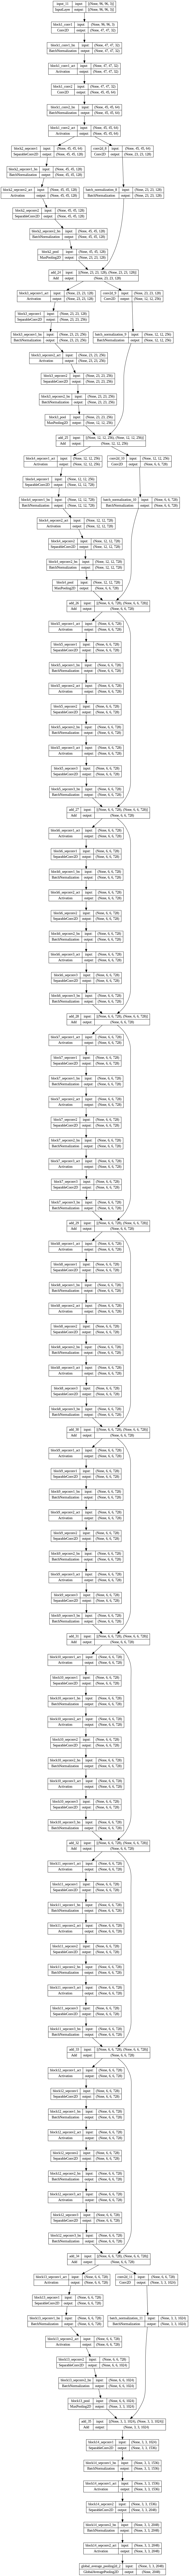

In [ ]:
xcep = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(xcep, show_shapes=True)

In [ ]:
# freeze all its weigths of the supernet
xcep.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))

# Connect xception to the input
x = xcep(inputs)

x = tfkl.Dense(units=512, activation='relu')(x)
dropout = tfkl.Dropout(dropout_rate, seed=seed)(x)
x = tfkl.Dense(units=256, activation='relu')(dropout)
dropout = tfkl.Dropout(dropout_rate, seed=seed)(x)

outputs = tfkl.Dense(2, activation='softmax')(dropout)

xcep_model = tfk.Model(inputs=inputs, outputs=outputs)

xcep_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# display model summary
xcep_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 2)                 514 

In [ ]:
# Train the model
xcep_history = xcep_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = callbacks,
    class_weight= class_weight
).history

Epoch 1/2000
45/45 [==============================] - 10s 111ms/step - loss: 0.6447 - accuracy: 0.6609 - val_loss: 0.5951 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/2000
45/45 [==============================] - 4s 82ms/step - loss: 0.4984 - accuracy: 0.7496 - val_loss: 0.4865 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 3/2000
45/45 [==============================] - 4s 81ms/step - loss: 0.4640 - accuracy: 0.7668 - val_loss: 0.5332 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 4/2000
45/45 [==============================] - 4s 87ms/step - loss: 0.4144 - accuracy: 0.7907 - val_loss: 0.4746 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 5/2000
45/45 [==============================] - 4s 80ms/step - loss: 0.3622 - accuracy: 0.8298 - val_loss: 0.5034 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 6/2000
45/45 [==============================] - 3s 68ms/step - loss: 0.3176 - accuracy: 0.8533 - val_loss: 0.5483 - val_accuracy: 0.7605 - lr: 0.0010
Epoch 7/2000
45/45 [==============================] - 4s 81ms/

In [ ]:
metadata['Xception'] = {
    'model': xcep_model,
    'history': xcep_history,
    'color': ('#007FFF', '#007FFF'),
    'best_epoch': np.argmax(xcep_history['val_accuracy'])
}

In [ ]:
# prediction based on test set
preds = xcep_model.predict(X_test, verbose=0)

print("Predictions Shape:", preds.shape)

Predictions Shape: (948, 2)


Accuracy: 0.7806
Precision: 0.7889
Recall: 0.7233
F1: 0.737


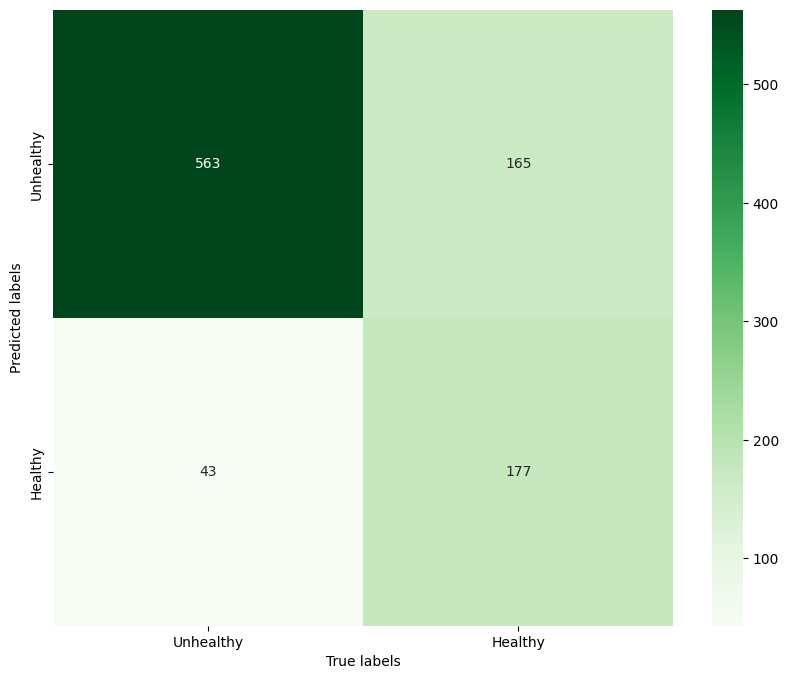

In [ ]:
# confusion matrix
confmat = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1))

accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')

# relevant stats for the model
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(confmat.T, annot=True, fmt="d", xticklabels=list(('Unhealthy','Healthy')), yticklabels=list(('Unhealthy','Healthy')), cmap='Greens')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

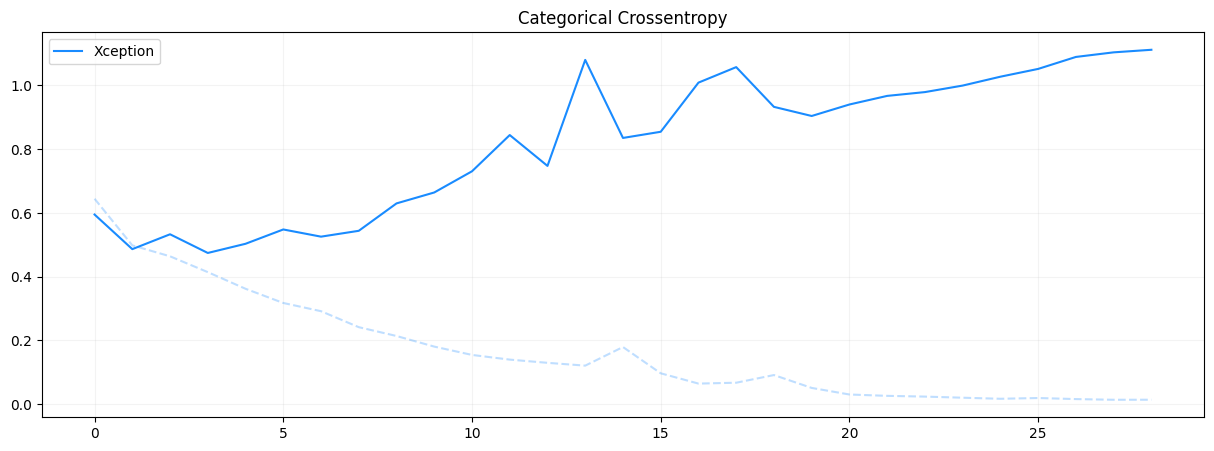

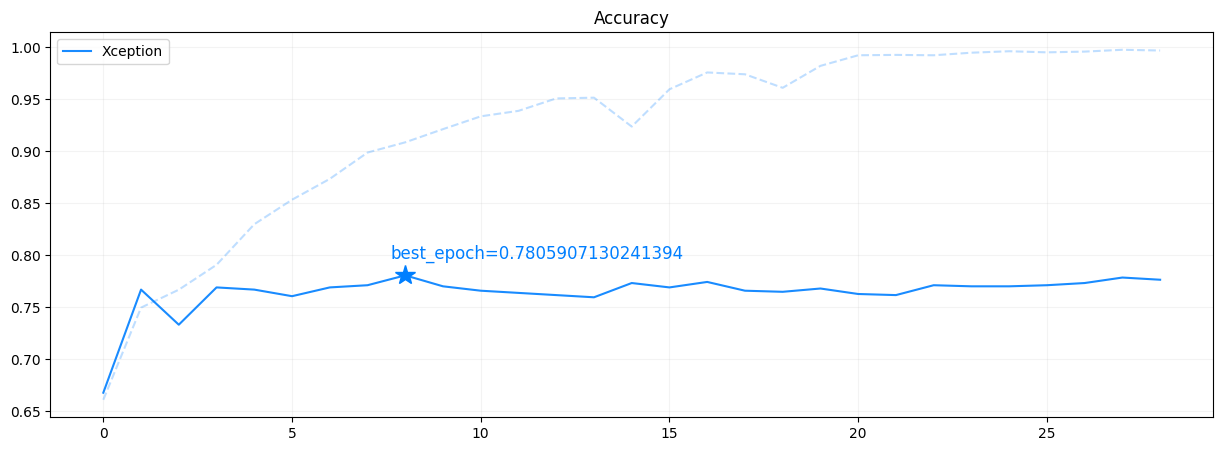

In [ ]:
print_histories(metadata)

#Fine Tuning Xception

In [ ]:
# Set all layers as trainable
xcep_model.get_layer('xception').trainable = True
for i, layer in enumerate(xcep_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_8 True
13 block2_pool True
14 batch_normalization_8 True
15 add_24 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_9 True
23 block3_pool True
24 batch_normalization_9 True
25 add_25 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_10 True
33 block4_pool True
34 batch_normalization_10 True
35 add_26 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
4

In [ ]:
# Freeze first N layers
N = 46
for i, layer in enumerate(xcep_model.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(xcep_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xcep_model.summary()

0 input_11 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_8 False
13 block2_pool False
14 batch_normalization_8 False
15 add_24 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_9 False
23 block3_pool False
24 batch_normalization_9 False
25 add_25 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_10 False
33 block4_pool False
34 batch_normalization_10 False
35 add_26 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_se

In [ ]:
# Compile the model
xcep_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [ ]:
# Fine-tune the model
xcep_history = xcep_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = callbacks,
    class_weight=class_weight
).history

Epoch 1/2000
45/45 [==============================] - 24s 182ms/step - loss: 0.5068 - accuracy: 0.7633 - val_loss: 1.7584 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/2000
45/45 [==============================] - 7s 153ms/step - loss: 0.2782 - accuracy: 0.8632 - val_loss: 1.6399 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 3/2000
45/45 [==============================] - 7s 145ms/step - loss: 0.1746 - accuracy: 0.9314 - val_loss: 1.9176 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 4/2000
45/45 [==============================] - 6s 140ms/step - loss: 0.1201 - accuracy: 0.9490 - val_loss: 1.0074 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 5/2000
45/45 [==============================] - 7s 157ms/step - loss: 0.0857 - accuracy: 0.9652 - val_loss: 4.0189 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 6/2000
45/45 [==============================] - 7s 145ms/step - loss: 0.0951 - accuracy: 0.9676 - val_loss: 0.7952 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 7/2000
45/45 [==============================] - 6s 

In [ ]:
metadata['Xception_ft'] = {
    'model': xcep_model,
    'history': xcep_history,
    'color': ('#FF9933', '#FF9933'),
    'best_epoch': np.argmax(xcep_history['val_accuracy'])
}

In [ ]:
preds = xcep_model.predict(preprocess_input(X_test*255), verbose=0)

print("Predictions Shape:", preds.shape)

Predictions Shape: (948, 2)


Accuracy: 0.8597
Precision: 0.8522
Recall: 0.8399
F1: 0.8453


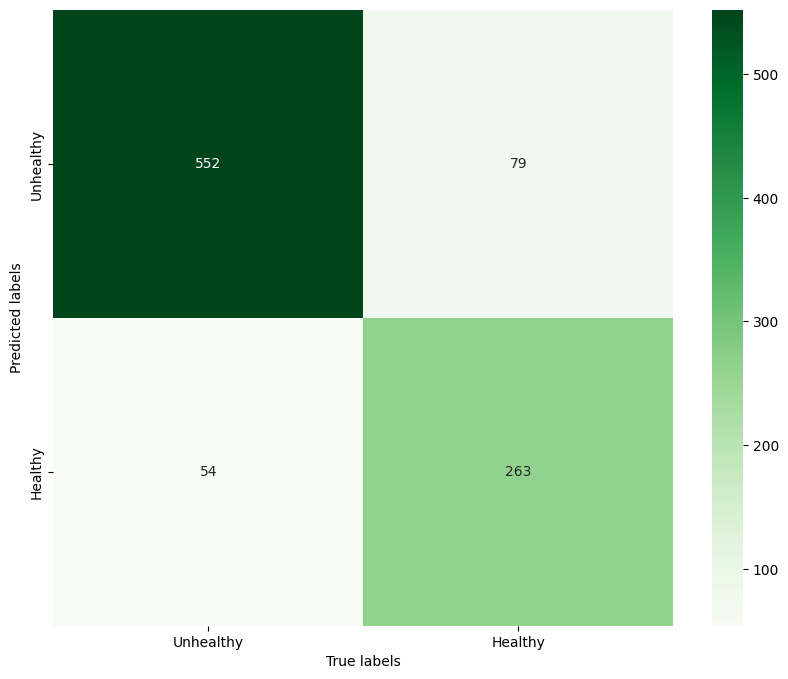

In [ ]:
confmat = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1))

accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='macro')

print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(confmat.T,annot=True, fmt="d", xticklabels=list(('Unhealthy','Healthy')), yticklabels=list(('Unhealthy','Healthy')), cmap='Greens')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

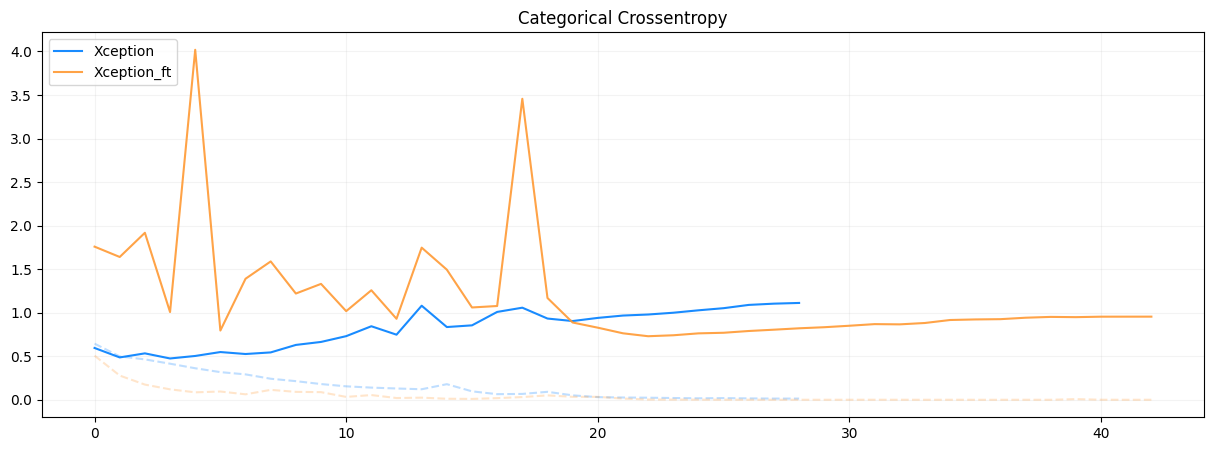

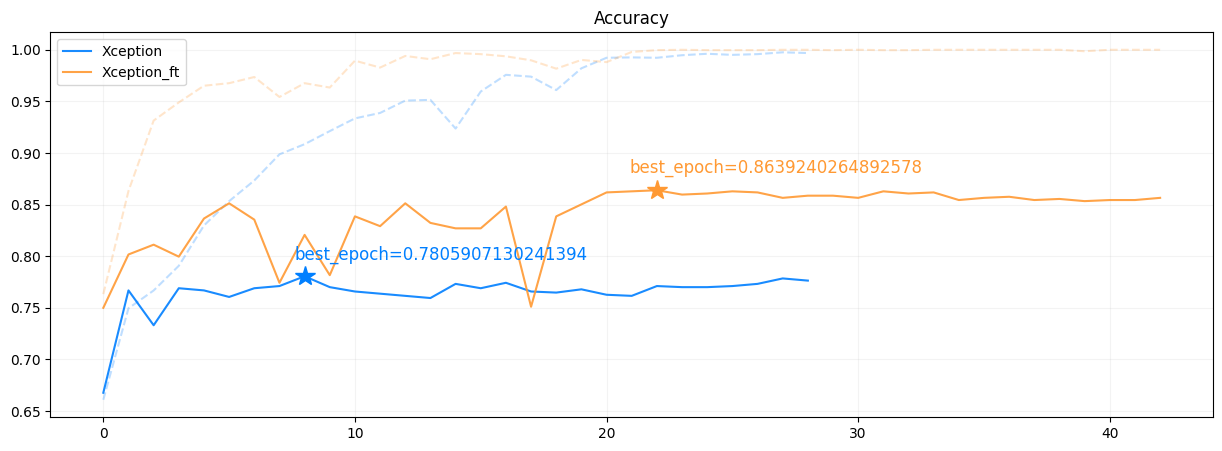

In [ ]:
print_histories(metadata)

In [ ]:
# Save the model
xcep_model.save('TransferLearnin&FineTuning_Xception')